#### Задача:
- Построение модели, которая по фотографии определит приблизительный возраст человека
- Необходимо достичь значения MAE на валидационной выборке не более 8

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Загрузка датасета с Kaggle https://www.kaggle.com/abhikjha/appa-real-face-cropped

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kovrigindanila","key":"d57260537163e9fffe943e5f05070842"}'}

In [5]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d abhikjha/appa-real-face-cropped --force

 88% 201M/228M [00:02<00:00, 62.4MB/s]
100% 228M/228M [00:02<00:00, 83.4MB/s]


In [0]:
!unzip -q -u -d appa-real-face-cropped/ appa-real-face-cropped.zip

In [0]:
labels = pd.read_csv('appa-real-face-cropped/labels.csv')

Путь к файлам

In [0]:
data_dir = 'appa-real-face-cropped/final_files/final_files/'

Изучение датасета с метками

In [41]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [42]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


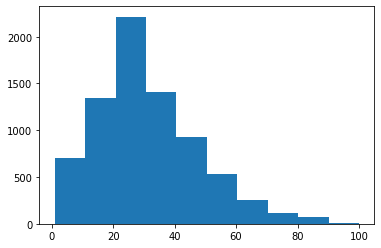

In [43]:
plt.hist(labels['real_age'])
plt.show()

Пропусков нет, медианный возраст 29 лет, распределение близко к нормальному

Изучение датасета изображений

In [51]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=data_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42)

Found 7591 validated image filenames.


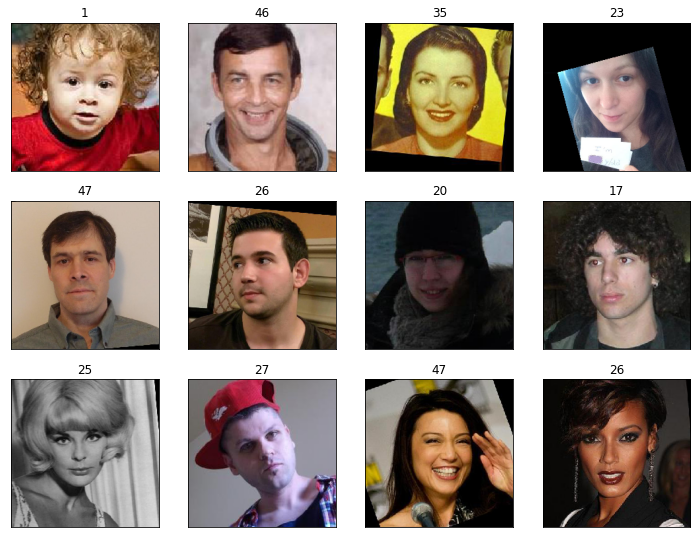

In [52]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### Вывод:
- Датасет цветных изображений лиц людей
- Распределение значений возраста близко к нормальному. Медиана около 29 лет

Создание обучающей и валидационной выборки в соотношении 75:25.

Попробую два варианта обучающей выборки - с аугментацией и без неё. В качестве аугментации применяется отражение по горизонтали.

In [0]:
def load_train(path, horizontal_flip):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=horizontal_flip)
    
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
 
    return train_datagen_flow

def load_valid(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
 
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
 
    return valid_datagen_flow

Использую нейросеть ResNet50 без двух последних слоёв, предобученную на датасете ImageNet. Алгоритм оптимизации Adam с различными значениями скорости обучения.

In [0]:
def create_model(lr):
 
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
    return model

def train_model(model, train_data, test_data, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model = model.fit(train_data,
              validation_data=test_data,epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=0)
 
    return model

Обучающая выборка с аугментацией

In [32]:
train_datagen_flow_aug = load_train(data_dir, True)

Found 5694 validated image filenames.


Обучающая выборка без аугментации

In [33]:
train_datagen_flow = load_train(data_dir, False)

Found 5694 validated image filenames.


Валидационная выборка

In [17]:
valid_datagen_flow = load_valid(data_dir)

Found 1897 validated image filenames.


Создание моделей с различными значениями `learning_rate`

In [0]:
learning_rate = [0.001, 0.0003, 0.0001]

In [0]:
models = []
for lr in learning_rate:
  model = create_model(lr)
  models.append(model)

Обучение моделей на данных с аугментацией

In [0]:
trained_models_aug = []
for model in models:
  trained_model = train_model(model, train_datagen_flow_aug, valid_datagen_flow, epochs=10,
                steps_per_epoch=None, validation_steps=None)
  trained_models_aug.append(trained_model)

Пересоздание моделей

In [0]:
models = []
for lr in learning_rate:
  model = create_model(lr)
  models.append(model)

Обучение моделей на данных без аугментации

In [0]:
trained_models = []
for model in models:
  trained_model = train_model(model, train_datagen_flow, test_datagen_flow, epochs=10,
                steps_per_epoch=None, validation_steps=None)
  trained_models.append(trained_model)

Построение графиков изменения MAE в процессе обучения и валидации моделей

In [0]:
def plot_models(models, title_aug):
  for i in range(len(models)):
    plt.plot(models[i].history['mae'], label='MAE train')
    plt.plot(models[i].history['val_mae'], label='MAE valid')
    plt.title(f'Model MAE(lr={learning_rate[i]}, {title_aug})')
    plt.ylabel('MAE')
    plt.xlabel('эпоха')
    plt.legend(loc="upper left")
    plt.show()

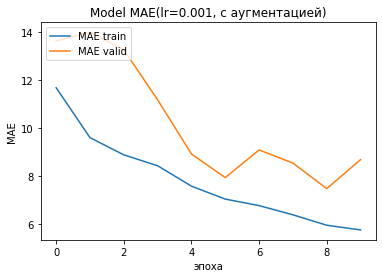

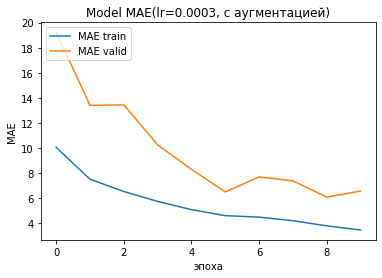

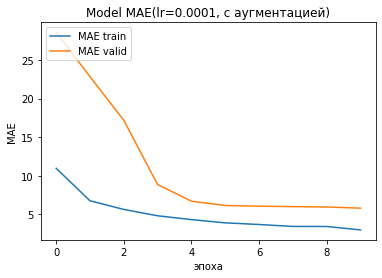

In [39]:
plot_models(trained_models_aug, 'с аугментацией')

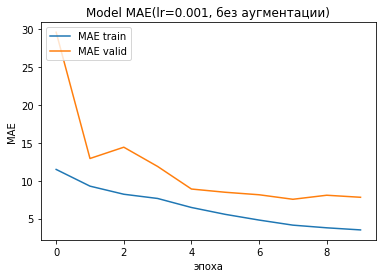

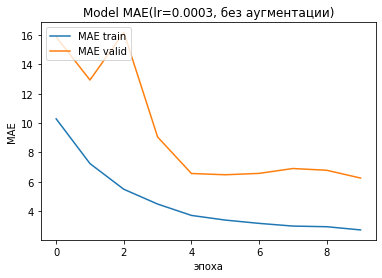

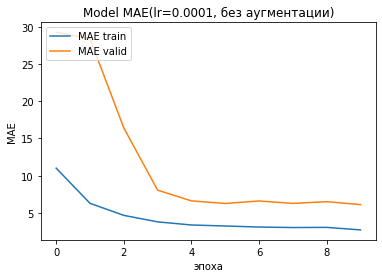

In [40]:
plot_models(trained_models, 'без аугментации')

#### Вывод:
- Удалось достичь MAE на валидационной выборке меньше 8
- Лучшее значение MAE 6.0505 на десятой эпохе было получено с аугментацией и шагом градиентного спуска 0.0003
- В целом аугментация положительно влияет на значение метрики, но применять её нужно с учётом особенностей анализируемых изображений
- После четвертой эпохи значения MAE приближаются к плато и перестают значительно снижаться. 